# Autoencoder as a Classifier using Fashion-MNIST Dataset

## Tous kodikes en tous etrexa giati itan na pari para polli ora.Apoti ekatalava en oti zita stin ergasia pano kato.To dataset en polla paromoio ara en nomizo na xriasti na allaksoume je polla 

Import necessary libraries

In [9]:
from google.colab import drive
drive.mount('/content/drive')
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import struct as st


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Function to read the data

In [10]:

def read_data(filename):
    file = gzip.open(filename,'rb')
    file.seek(0)
    magic_number = st.unpack('>4B',file.read(4)) # read magic number
    number_of_images = st.unpack('>I',file.read(4))[0] # read number of images
    number_of_rows = st.unpack('>I',file.read(4))[0] #read number of rows
    number_of_columns = st.unpack('>I',file.read(4))[0] #read number of column
    with gzip.open(filename) as file_stream:
        file_stream.read(16)
        buf = file_stream.read(number_of_rows * number_of_columns * number_of_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(number_of_images, number_of_rows,number_of_columns)
        return data

In [12]:
train_data = read_data('/content/train-images-idx3-ubyte.gz')
test_data = read_data('/content/t10k-images-idx3-ubyte.gz')

Function to read labels

In [13]:

def read_labels(filename):
    file = gzip.open(filename,'rb')
    file.seek(0)
    magic_number = st.unpack('>4B',file.read(4)) # read magic number
    number_of_iteams = st.unpack('>I',file.read(4))[0] # read number of images
    with gzip.open(filename) as file_stream:
        file_stream.read(8)
        buf = file_stream.read(number_of_iteams)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [14]:
train_labels = read_labels('/content/train-labels-idx1-ubyte.gz')
test_labels = read_labels('/content/t10k-labels-idx1-ubyte.gz')

In [15]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [16]:
# Create dictionary of target classes
label_dict = {
 0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
}

Inspect some of the images in the dataset:

Text(0.5, 1.0, '(Label: 0)')

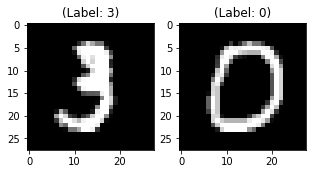

In [17]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")


Data Preprocessing

Reshape the images

In [18]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Rescale the training and testing data with the maximum pixel value of the training and testing data:

In [19]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

Partition the data.
Split the data to a training and a validation set


In [20]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

## The Convolutional Autoencoder

In [21]:
batch_size = 256
epochs = 100
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [23]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='softmax', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='softmax', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='softmax', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='softmax', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='softmax', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='softmax', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='softmax', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='softmax', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(256, (3, 3), activation='softmax', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='softmax', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(128, (3, 3), activation='softmax', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='softmax', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(64, (3, 3), activation='softmax', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='softmax', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

Compile the model using the optimizer to be RMSProp and mean squared error for loss function

In [24]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [26]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)       

Train the model

In [27]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/100
188/188 [==============================] - 20s 108ms/step - loss: 0.0764 - val_loss: 0.1024
Epoch 2/100
188/188 [==============================] - 20s 105ms/step - loss: 0.0318 - val_loss: 0.1058
Epoch 3/100
188/188 [==============================] - 20s 106ms/step - loss: 0.0209 - val_loss: 0.1001
Epoch 4/100
188/188 [==============================] - 20s 107ms/step - loss: 0.0139 - val_loss: 0.0785
Epoch 5/100
188/188 [==============================] - 20s 108ms/step - loss: 0.0103 - val_loss: 0.0128
Epoch 6/100
188/188 [==============================] - 20s 109ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 7/100
188/188 [==============================] - 21s 110ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 8/100
188/188 [==============================] - 21s 109ms/step - loss: 0.0061 - val_loss: 0.0075
Epoch 9/100
188/188 [==============================] - 20s 109ms/step - loss: 0.0054 - val_loss: 0.0062
Epoch 10/100
188/188 [==============================] - 21s 109m

Plot the loss plot between training and validation data to visualize the model performance.

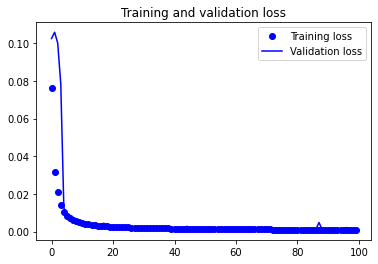

In [28]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Save the Model

In [29]:
autoencoder.save_weights('autoencoder.h5')
autoencoder.save('autoencoder')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: autoencoder/assets


In [30]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])


Original label: 5
After conversion to one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Split the data into training and validation for classification.

In [31]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)

Define the classification model

Define the fully connected layers that we will be stacking up with the encoder function.

In [32]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [33]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())


Print the weigths of the encoder part of the autoencoder and the weights we loaded to the encoder function of the classification model,to make sure they are similiar


In [34]:
autoencoder.get_weights()[0][1]

array([[[ 0.01326538,  0.05111954,  0.07798465, -0.2040455 ,
         -0.04614031,  0.03693153,  0.1330857 , -0.19012187,
          0.1473141 ,  0.02598264, -0.01397217,  0.2313203 ,
          0.10932448, -0.19449852,  0.2078724 , -0.0604379 ,
          0.03515921,  0.07322516, -0.16371928,  0.29997274,
          0.08726493,  0.02256622,  0.0207953 ,  0.12045008,
         -0.02659151, -0.08498931,  0.0022106 , -0.05190343,
          0.180119  , -0.01209491, -0.02642625, -0.00718168]],

       [[-0.03372496, -0.02386622, -0.03782235, -0.07968414,
         -0.03008815, -0.08287616,  0.03398599, -0.8800927 ,
         -0.12517817, -0.07500699, -0.06717091, -0.05059412,
          0.01924538, -0.02456672,  0.3336961 , -0.09250865,
         -0.01218271,  0.07550274, -0.01826648,  0.11721666,
          0.18684097,  0.01007517, -0.19389322, -0.08192933,
          0.09109673, -0.01009991,  0.04815964,  0.13427566,
          0.14950304, -0.07709581, -0.07527935,  0.09557661]],

       [[ 0.165677

In [35]:
full_model.get_weights()[0][1]

array([[[ 0.01326538,  0.05111954,  0.07798465, -0.2040455 ,
         -0.04614031,  0.03693153,  0.1330857 , -0.19012187,
          0.1473141 ,  0.02598264, -0.01397217,  0.2313203 ,
          0.10932448, -0.19449852,  0.2078724 , -0.0604379 ,
          0.03515921,  0.07322516, -0.16371928,  0.29997274,
          0.08726493,  0.02256622,  0.0207953 ,  0.12045008,
         -0.02659151, -0.08498931,  0.0022106 , -0.05190343,
          0.180119  , -0.01209491, -0.02642625, -0.00718168]],

       [[-0.03372496, -0.02386622, -0.03782235, -0.07968414,
         -0.03008815, -0.08287616,  0.03398599, -0.8800927 ,
         -0.12517817, -0.07500699, -0.06717091, -0.05059412,
          0.01924538, -0.02456672,  0.3336961 , -0.09250865,
         -0.01218271,  0.07550274, -0.01826648,  0.11721666,
          0.18684097,  0.01007517, -0.19389322, -0.08192933,
          0.09109673, -0.01009991,  0.04815964,  0.13427566,
          0.14950304, -0.07709581, -0.07527935,  0.09557661]],

       [[ 0.165677


We make the encoder part i.e.the first nineteen layers of the model trainable false. Since the encoder part is already trained,we do not need to train it. We will only be training the Fully Connected part.

In [36]:
for layer in full_model.layers[0:19]:
    layer.trainable = False


Compile the model

In [37]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [38]:
full_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 64)       

Train the Model



In [39]:
classify_train = full_model.fit(train_X, train_label, batch_size=256,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/100
188/188 [==============================] - 4s 22ms/step - loss: 0.1998 - accuracy: 0.9396 - val_loss: 0.0914 - val_accuracy: 0.9723
Epoch 2/100
188/188 [==============================] - 4s 20ms/step - loss: 0.0557 - accuracy: 0.9845 - val_loss: 0.0757 - val_accuracy: 0.9778
Epoch 3/100
188/188 [==============================] - 4s 20ms/step - loss: 0.0293 - accuracy: 0.9923 - val_loss: 0.0663 - val_accuracy: 0.9804
Epoch 4/100
188/188 [==============================] - 4s 20ms/step - loss: 0.0176 - accuracy: 0.9959 - val_loss: 0.0641 - val_accuracy: 0.9808
Epoch 5/100
188/188 [==============================] - 4s 20ms/step - loss: 0.0096 - accuracy: 0.9984 - val_loss: 0.0597 - val_accuracy: 0.9818
Epoch 6/100
188/188 [==============================] - 4s 20ms/step - loss: 0.0051 - accuracy: 0.9996 - val_loss: 0.0598 - val_accuracy: 0.9822
Epoch 7/100
188/188 [==============================] - 4s 20ms/step - loss: 0.0031 - accuracy: 0.9998 - val_loss: 0.0583 - val_accuracy:

Save the classification model

In [40]:
full_model.save_weights('autoencoder_classification.h5')

 Re-train the model by making the first nineteen layers trainable as True

In [41]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

    full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

Train the entire model for one last time

In [42]:
classify_train = full_model.fit(train_X, train_label, batch_size=256,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/100
188/188 [==============================] - 12s 62ms/step - loss: 2.0037e-08 - accuracy: 1.0000 - val_loss: 0.1136 - val_accuracy: 0.9858
Epoch 2/100
188/188 [==============================] - 11s 60ms/step - loss: 6.5565e-09 - accuracy: 1.0000 - val_loss: 0.1196 - val_accuracy: 0.9855
Epoch 3/100
188/188 [==============================] - 11s 60ms/step - loss: 3.6259e-09 - accuracy: 1.0000 - val_loss: 0.1226 - val_accuracy: 0.9852
Epoch 4/100
188/188 [==============================] - 11s 61ms/step - loss: 2.8114e-09 - accuracy: 1.0000 - val_loss: 0.1204 - val_accuracy: 0.9852
Epoch 5/100
188/188 [==============================] - 11s 60ms/step - loss: 2.1706e-09 - accuracy: 1.0000 - val_loss: 0.1225 - val_accuracy: 0.9854
Epoch 6/100
188/188 [==============================] - 11s 60ms/step - loss: 1.8924e-09 - accuracy: 1.0000 - val_loss: 0.1197 - val_accuracy: 0.9855
Epoch 7/100
188/188 [==============================] - 11s 60ms/step - loss: 1.7881e-09 - accuracy: 1.0000

Save the model

In [43]:
full_model.save_weights('classification_complete.h5')

Plot the accuracy and loss plots between training and validation data:

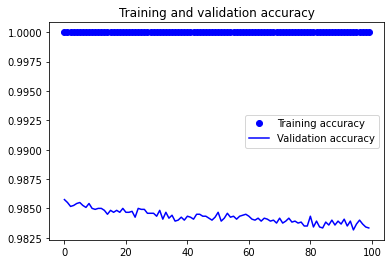

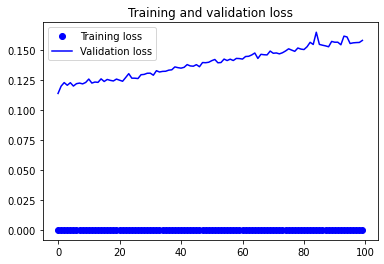

In [44]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Model Evaluation on the Test Set


In [45]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.15347415208816528
Test accuracy: 0.9832000136375427


Predict Labels

In [46]:
predicted_classes = full_model.predict(test_data)

In [47]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_labels.shape

((10000,), (10000,))

Found 9832 correct labels


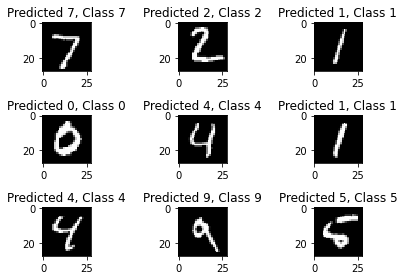

In [48]:
correct = np.where(predicted_classes==test_labels)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Found 168 incorrect labels


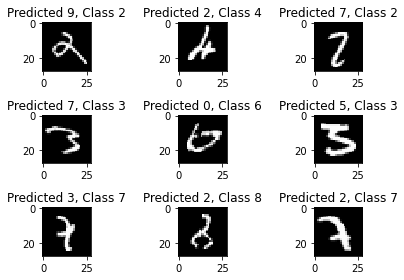

In [49]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

Classification Report


In [50]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99       980
     Class 1       0.99      0.99      0.99      1135
     Class 2       0.98      0.98      0.98      1032
     Class 3       0.98      0.99      0.98      1010
     Class 4       0.99      0.99      0.99       982
     Class 5       0.98      0.98      0.98       892
     Class 6       0.99      0.98      0.99       958
     Class 7       0.99      0.98      0.98      1028
     Class 8       0.98      0.98      0.98       974
     Class 9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

